In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist,cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation ,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc,precision_score, recall_score,f1_score,accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import matplotlib.pyplot as plt
from skimage import transform
import scipy.ndimage
import matplotlib.pyplot as plt

from keras.layers import Lambda, Input
from keras.models import Model, Sequential
import tensorflow as ktf

In [20]:
# Prepare the training dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [21]:
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [22]:
# Prepare the validation dataset.
# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

In [23]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = keras.layers.Dense(64, activation="relu")(inputs)
x2 = keras.layers.Dense(64, activation="relu")(x1)
outputs = keras.layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

In [24]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [25]:
# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [26]:
#import datetime, os
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [27]:
from keras.callbacks import TensorBoard
callback = [TensorBoard(log_dir='./logs')]

In [28]:
def plothist():
    
    plt.subplot(1, 2, 1)
    plt.plot(plot_acc_train)
    plt.plot(plot_acc_val)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.legend(['train', 'val'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(plot_loss_train)
    plt.plot(plot_loss_val)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('step')
    plt.legend(['train', 'val'], loc='upper right')

    plt.show()

In [34]:
class PlotLearning():
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('plot_loss_train'))
        self.val_losses.append(logs.get('plot_loss_val'))
        self.acc.append(logs.get('plot_acc_train'))
        self.val_acc.append(logs.get('plot_acc_val'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show()
        
plot = PlotLearning()


Start of epoch 0
Training loss (for one batch) at step 0: 0.5484
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.3479
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.5027
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.5711
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.4283
Seen so far: 51264 samples
Training acc over epoch: 0.8711
Validation loss: 0.0564
Validation acc: 0.8965


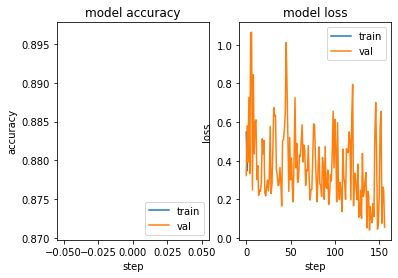


Start of epoch 1
Training loss (for one batch) at step 0: 0.6865
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.6832
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.2121
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.4233
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.3423
Seen so far: 51264 samples
Training acc over epoch: 0.8871
Validation loss: 0.0777
Validation acc: 0.9078


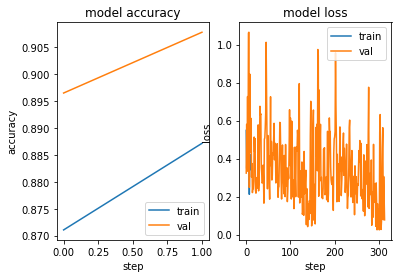

In [32]:
import time

epochs = 2
plot_loss_train=[]
plot_acc_train=[]
plot_loss_val=[]
plot_acc_val=[]
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 64))
            plot_loss_train+=[loss_value]



    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    plot_acc_train+=[train_acc]
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_loss = loss_fn(y_batch_val, val_logits)
        val_acc_metric.update_state(y_batch_val, val_logits)
        plot_loss_val+=[val_loss]
        
    val_acc = val_acc_metric.result()
    plot_acc_val+=[val_acc]
    val_acc_metric.reset_states()
    print("Validation loss: %.4f" % (float(val_loss),))
    print("Validation acc: %.4f" % (float(val_acc),))
    plothist()
   

    

In [31]:
class LogCallback(keras.callbacks.Callback):
  
  def on_epoch_end(self, epoch, logs=None):
    print(logs["train_acc"])